<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/SSD_Tensorflow_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **SSD on Images**

In [1]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 81861, done.
remote: Counting objects: 100% (328/328), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 81861 (delta 197), reused 261 (delta 157), pack-reused 81533
Receiving objects: 100% (81861/81861), 596.33 MiB | 16.47 MiB/s, done.
Resolving deltas: 100% (58386/58386), done.


In [2]:
# install protobuf if running this notebook on local before running this

# this helps to check if prorobuf has been installed successfully and added to the environ variables
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

**Installing the Object detection API**

In [3]:
!cd models/research && \
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

# to install models still under testing
# !cd models/research && python object_detection/builders/model_builder_tf2_test.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 111.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 5

**Import Libraries**

In [20]:
import os
import pathlib
import tensorflow as tf

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image  # for reading in image, could use opencv too
import matplotlib.pyplot as plt
%matplotlib inline

**Download Images to be used for object detection**

In [5]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

--2023-03-03 04:44:51--  https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195368 (191K) [image/jpeg]
Saving to: ‘walkingdog.jpeg’

walkingdog.jpeg     100%[===================>] 190.79K   963KB/s    in 0.2s    

2023-03-03 04:44:53 (963 KB/s) - ‘walkingdog.jpeg’ saved [195368/195368]

--2023-03-03 04:44:53--  https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160514 (157K) [image/jpeg]
Saving to: ‘traffic.jpeg’

traffic.jpeg        100

In [6]:
IMAGE_PATHS = ["intersection.jpeg", "traffic.jpeg", "jungle.jpeg", "walkingdog.jpeg"]

**Download pretrained_models AND label file**

link to see more models for use case: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md


link to see more labels for use case: https://github.com/tensorflow/models/tree/master/research/object_detection/data

In [7]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'

# downloads and extracts model tar file and stores the dir
PATH_TO_MODEL_DIR = tf.keras.utils.get_file("ssd_resnet101_v1_fpn_640x640_coco17_tpu-8",
                                            origin = url, untar = True)

PATH_TO_MODEL_DIR

386527459/386527459 [==============================] - 3s 0us/step


'/root/.keras/datasets/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'

In [8]:
# downloads the labels file (coco dataset labels file)
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(
    fname = "mscoco_label_map.pbtxt",
    origin = url,
    untar = False
)

PATH_TO_LABELS

5056/5056 [==============================] - 0s 0us/step


'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [9]:
# view some labels
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


**Load in the model and labels**

In [10]:
PATH_TO_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print("Loading_model....", end ="")
start_time = time.time()

#load saved model and build the obj detection function for use
detect_fn = tf.saved_model.load(PATH_TO_MODEL)

end_time = time.time()

load_time = end_time - start_time
print(f"Done! Took: {load_time} seconds")

Loading_model....Done! Took: 31.560322046279907 seconds


In [11]:
# loads the labels
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS,
    use_display_name = True
)

category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

**Build Helper Functions**

In [35]:
def load_img_into_numpy_array(path):
  """
  loads image from file into a np array to feed to tf model
  note: Color channel of image should be RGB so if using cv2 to load image ensure to convert channel to RGB

  Args:
      path: the file path to the image

  Returns:
      uint8 numpy array with shape (img_height, img_width, 3)

  """
  img = Image.open(path)
  return np.array(img)


def detect_objects(image_path):
  """
  loads in image and detect objects
  """
  print(f"Detecting objects... in {image_path} ", end = "")
  img_np = load_img_into_numpy_array(image_path)

  # converts input to tensor for feeding to model and batch it
  input_tensor = tf.convert_to_tensor(img_np)[tf.newaxis, ...]

  # detect obj in img
  detections = detect_fn(input_tensor)

  # print the raw output
  # print(detections)

  # all outputs are batch tensors i.e have axis 0 of 1
  # conv to np arrays and take index[0] to remove batch_dim
  # interested in data for just first num_detections
  num_detections = int(detections.pop("num_detections"))
  detections = {key: value[0, :num_detections].numpy() 
                for key, value in detections.items()}

  detections["num_detections"] = num_detections

  # conv detection classes to ints to easier mapping to labels
  detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

  # show classes
    # unique_classes = set(detections['detection_classes'])
    # print("Classes found:")
    # for c in unique_classes:
    #     print(category_index[c]['name'])


  # makes copy of images to draw detection boxes on
  image_np_with_detections = img_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections["detection_boxes"],
      detections["detection_classes"],
      detections["detection_scores"],
      category_index,
      use_normalized_coordinates = True,
      max_boxes_to_draw = 200,
      min_score_thresh = .5,
      agnostic_mode = False
  )

  plt.figure(figsize=(15, 10))
  plt.imshow(image_np_with_detections)
  print('Done')
  plt.show()

Detecting objects... in walkingdog.jpeg Done


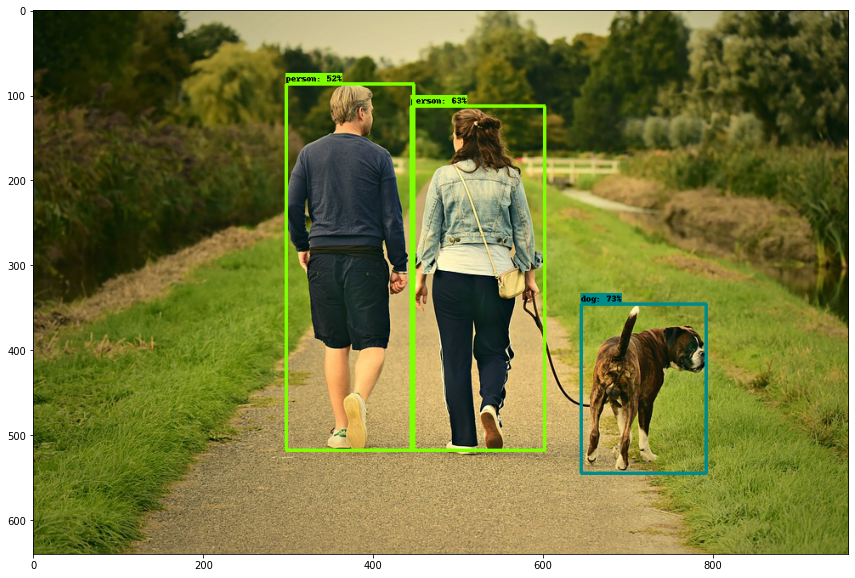

In [36]:
detect_objects(IMAGE_PATHS[3])

Detecting objects... in dog.jpgDone


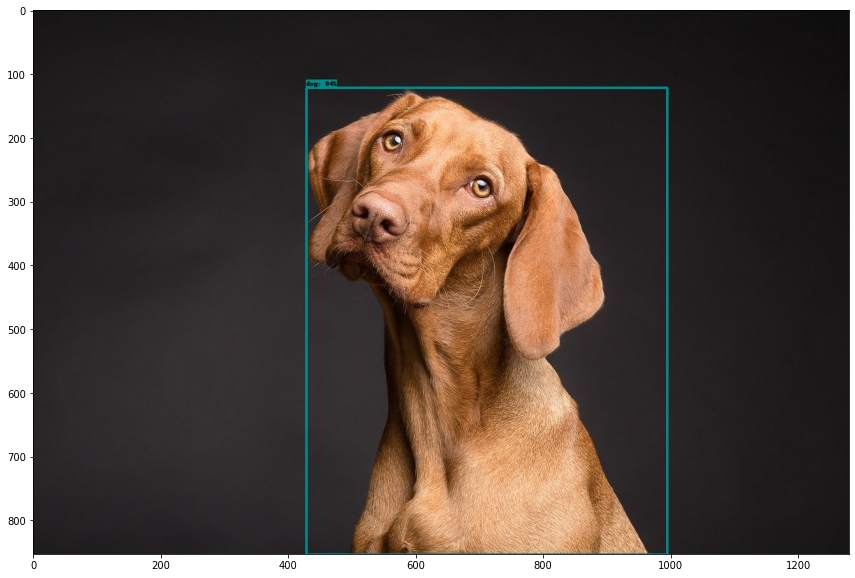

In [31]:
detect_objects("dog.jpg")